# Recharge scaling and baseflow ensemble

Steps:
- Perform baseflow separation (ensemble methods) for observed discharge time series.
- Compare ensemble baseflow production vs JULES sub-surface runoff over km105 to derive a scaling factor.
- Apply scaling, generate historical mean and monthly mean recharge, and save PSAD rasters for use in preprocessing.


In [15]:
## RUN THIS WITH MFLOW ENVIRONMENT
#------------ 
from pathlib import Path
import calendar
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import dask
import matplotlib.pyplot as plt

import baseflow as bf

PSAD_CRS = "EPSG:24893"
BUFFER_METERS = 2000

# Paths
mountain_dir = Path('/home/jec18/modflow/jupy/VUB/mountain')
reproj_dir = mountain_dir / 'reprojected'
rasters_dir = reproj_dir / 'rasters'
vectors_dir = reproj_dir / 'vectors'
out_dir = mountain_dir / 'prepared'
for p in (out_dir,):
    p.mkdir(parents=True, exist_ok=True)

# Inputs
catchment_psad = vectors_dir / 'km105_psad.gpkg'
bbox_psad = vectors_dir / 'km105_bbox_buffered.gpkg'
obs_discharge_path = Path('/home/clara/project/rahu/data-raw/Caudales_Vilcanota_SENAMHI.xlsx')  # observed Q (SENAMHI)
stations = ["EGEMSA_KM105", "PISAC"]
jules_daily_pattern = '/home/clara/project/rahu/jules-output/freedrain_jose/JULES_vn6.1.S2.daily_hydrology.*.2D.nc'
land_frac_nc = '/home/clara/rahu_data/netcdf/jules_land_frac_ESA_rahu_clipped.nc'
area_nc = Path('/home/clara/rahu_data/netcdf/gridcell_area_km105.nc')

# Outputs
baseflow_monthly_csv = out_dir / 'baseflow_monthly_ensemble.csv'
baseflow_stats_csv = out_dir / 'baseflow_stats_ensemble.csv'
scaling_json = out_dir / 'recharge_scaling.json'
recharge_ann_tif = out_dir / 'recharge_FD_jules_scaled.tif'
recharge_mon_tif = out_dir / 'recharge_m_FD_jules_scaled.tif'


## Catchment and land fraction
- Load km105 catchment and buffered bbox (PSAD).
- Open land-fraction NetCDF with engine fallbacks; set CRS if missing.
- Clip land fraction to the bbox for later weighting.

In [16]:
catch = gpd.read_file(catchment_psad)
catch = catch.to_crs(PSAD_CRS)
bbox = gpd.read_file(bbox_psad).to_crs(PSAD_CRS)

# Load land fraction (used to mask/weight) with engine fallback
engines = ("netcdf4", "h5netcdf", "scipy")
land_frac_ds = None
last_err = None
for eng in engines:
    try:
        land_frac_ds = xr.open_dataset(land_frac_nc, engine=eng)
        print(f"Opened land fraction with engine={eng}")
        break
    except Exception as exc:
        last_err = exc
        continue
if land_frac_ds is None:
    raise RuntimeError(f"Failed to open {land_frac_nc} with engines {engines}; last error: {last_err}")
land_frac = land_frac_ds['land_frac']
if not hasattr(land_frac, 'rio'):
    land_frac = land_frac.rio.write_crs("EPSG:4326", inplace=False)
if land_frac.rio.crs is None:
    land_frac = land_frac.rio.set_crs("EPSG:4326")
    print("Land fraction CRS missing; set to EPSG:4326")

# Clip land fraction to bbox in its own CRS
bbox_landfrac = bbox.to_crs(land_frac.rio.crs)
minx, miny, maxx, maxy = bbox_landfrac.total_bounds
land_frac_clip = land_frac.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
land_frac_clip = land_frac_clip.where(~np.isnan(land_frac_clip), 0)


Opened land fraction with engine=netcdf4
Land fraction CRS missing; set to EPSG:4326


/tmp/ipykernel_1034088/389737074.py:23: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  land_frac = land_frac.rio.set_crs("EPSG:4326")


## Baseflow separation (ensemble)
Use `baseflow` package as in `water_balance_gw.ipynb`, computing multiple methods and summarizing monthly means and BFI statistics.

In [17]:
# Load observed discharge (Excel from SENAMHI)
df_q = pd.read_excel(
    obs_discharge_path,
    header=0,
    index_col=0,
    skiprows=[1, 2, 3],
    parse_dates=True,
)

missing = [s for s in stations if s not in df_q.columns]
if missing:
    raise ValueError(f"Missing stations in observed data: {missing}")

df_q = df_q[stations]

# Run ensemble separation
separated, bfi, kge = bf.separation(df_q, return_kge=True, return_bfi=True)

# Monthly means per method per station
monthly = {method: dframe.groupby(dframe.index.month).mean() for method, dframe in separated.items()}
monthly_df = pd.concat(monthly, axis=1)
monthly_df.index = pd.Index([calendar.month_abbr[m] for m in monthly_df.index], name='month')
monthly_df.to_csv(baseflow_monthly_csv)

# BFI stats (handle dict/list/array shapes robustly)
if isinstance(bfi, dict):
    bfi_df = pd.DataFrame.from_dict(bfi, orient='index', columns=['BFI'])
elif hasattr(bfi, '__len__') and not isinstance(bfi, (str, bytes)):
    bfi_df = pd.DataFrame(bfi)
    if bfi_df.shape[0] == len(separated):
        bfi_df.index = list(separated.keys())
    elif bfi_df.shape[1] == len(separated):
        bfi_df = bfi_df.T
        bfi_df.index = list(separated.keys())
    bfi_df.columns = [f'BFI_{i}' for i in range(bfi_df.shape[1])]
else:
    bfi_df = pd.DataFrame({'BFI': [bfi]})

bfi_df.to_csv(baseflow_stats_csv)

print('Saved baseflow monthly to', baseflow_monthly_csv)
print('Saved baseflow stats to', baseflow_stats_csv)
monthly_df.head()


100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

Saved baseflow monthly to /home/jec18/modflow/jupy/VUB/mountain/prepared/baseflow_monthly_ensemble.csv
Saved baseflow stats to /home/jec18/modflow/jupy/VUB/mountain/prepared/baseflow_stats_ensemble.csv


UKIH                    Local                    Fixed  \
      EGEMSA_KM105       PISAC EGEMSA_KM105       PISAC EGEMSA_KM105   
month                                                                  
Jan     160.462408   87.818883   169.411562   90.935363   177.835343   
Feb     216.567275  111.439682   221.570229  115.397340   230.342900   
Mar     217.390967  107.063810   220.542572  111.146099   231.479123   
Apr     146.927687   74.328819   147.900717   73.863685   144.454300   
May      72.812566   41.416577    74.000396   40.992981    69.613888   

                         Slide                       LH              ...  \
            PISAC EGEMSA_KM105       PISAC EGEMSA_KM105       PISAC  ...   
month                                                                ...   
Jan     90.256387   175.632333   90.340123   158.910392   83.872564  ...   
Feb    119.736107   232.448591  119.243433   213.356340  110.574419  ...   
Mar    111.271607   230.782407  111.847389   206.398245  101.256919  ...   
Apr     72.985005   144.689150   73.003004   122.186218   62.688288  ...   
May     39.643942    69.138178   39.732293    61.805565   36.262921  ...   

          Boughton                    Furey                 Eckhardt  \
      EGEMSA_KM105       PISAC EGEMSA_KM105       PISAC EGEMSA_KM105   
month                                                                  
Jan     145.522810   79.437252   140.915219   77.207913   144.613395   
Feb     203.765467  110.026483   199.119495  107.597189   202.829031   
Mar     220.917283  111.419076   217.693119  109.968430   220.243840   
Apr     154.413645   77.951643   153.543399   77.528262   154.249274   
May      74.904246   41.813039    74.815828   41.731440    74.896814   

                          EWMA                  Willems              
            PISAC EGEMSA_KM105       PISAC EGEMSA_KM105       PISAC  
month                                                                
Jan     79.397238   143.760893   74.389201   143.329182   78.597724  
Feb    109.989488   205.082001  106.989889   201.556666  109.062208  
Mar    111.399964   225.022117  111.632973   219.387633  110.822031  
Apr     77.943917   156.834532   78.572868   153.998293   77.793164  
May     41.812156    75.578630   42.345722    74.860682   41.778061  

[5 rows x 24 columns]

## Load JULES daily hydrology, clip to bbox, and compute baseflow production
- Sub-surface runoff (`sub_surf_roff`) represents baseflow production.
- Clip to bbox; then area-weight to catchment; aggregate to monthly and annual means.
- Compare to ensemble baseflow to derive scaling factor (ratio of observed baseflow to JULES baseflow).

In [18]:
# Load JULES daily hydrology with open_mfdataset (assumes dask installed)
files="/home/clara/project/rahu/jules-output/freedrain_jose/JULES_vn6.1.S2.daily_hydrology.*.2D.nc"
recharge = xr.open_mfdataset(files,decode_coords="all")
recharge=recharge.sub_surf_roff.sel(time=recharge.time.dt.year.isin(np.arange(2000,2019)),drop=True).groupby("time.month").mean("time")
# Ensure CRS is set (JULES hydrology outputs are lat/lon WGS84)
if not hasattr(recharge, 'rio') or recharge.rio.crs is None:
    recharge = recharge.rio.write_crs("EPSG:4326")
    
cell_area = xr.open_dataset(area_nc).area
# Baseflow production (m/s -> m3/s per cell)
baseflow_vol = (recharge * cell_area/1000).sum(dim=["lat","lon"])

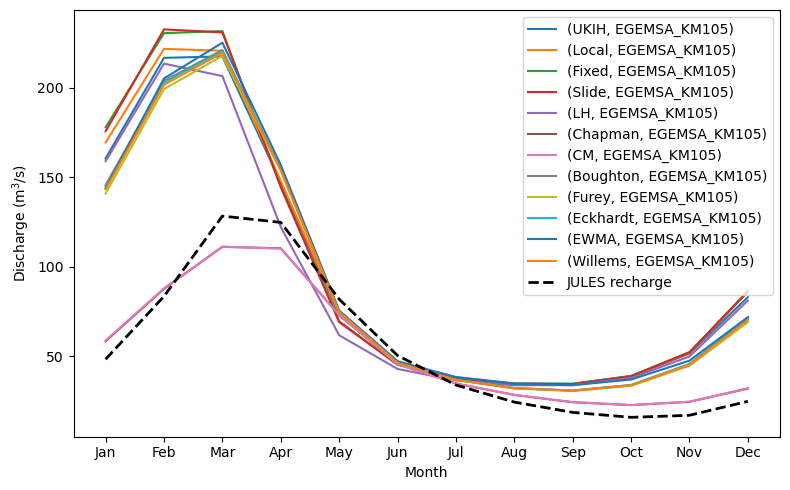

In [19]:
models = monthly_df.filter(like="EGEMSA_KM105")   # pandas df
jules_fd = baseflow_vol                           # xarray DataArray
y_fd = jules_fd.values  # JULES free drain
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
x = np.arange(12)
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8,5))

# Plot all EGEMSA_KM105 lines first (pandas handles its own colors)
models.plot(ax=ax)

# Add JULES free drain (black dashed)
ax.plot(
    x, y_fd,
    label="JULES recharge",
    linestyle="--",
    linewidth=2,
    color="black",
)
ax.set_xticks(x)
ax.set_xticklabels(months)

ax.set_xlabel("Month")
ax.set_ylabel("Discharge (m$^3$/s)")
ax.legend()
plt.tight_layout()
plt.show()


In [20]:
models_no_cm = models.drop(columns="CM", level=0)
monthly_mean = models_no_cm.mean(axis=1)
obs_annual_mean=monthly_mean.mean()
recharge_mean_annual= baseflow_vol.mean().values
scale_factor = (obs_annual_mean) / (float(recharge_mean_annual))
print('Scaling factor (obs/JULES):', scale_factor)

Scaling factor (obs/JULES): 1.6553175998518967


## Apply scaling and export recharge rasters
Use scaling factor on JULES sub-surface runoff to create annual mean and monthly mean recharge rasters in PSAD for preprocessing. NetCDF handling stays separate.

In [21]:
recharge_scaled = recharge * scale_factor / 1000 # m/s

# Annual mean
recharge_mean = recharge_scaled.mean('month')
recharge_mean = recharge_mean.rio.write_crs(recharge.rio.crs)
recharge_mean_psad = recharge_mean.rio.reproject(PSAD_CRS)
recharge_mean_psad.rio.to_raster(recharge_ann_tif)

# Monthly mean (12 bands)
recharge_months_psad = recharge_scaled.rio.reproject(PSAD_CRS)
recharge_months_psad.rio.to_raster(recharge_mon_tif)

# Save scaling metadata
pd.Series({'scale_factor_obs_over_jules': scale_factor}).to_json(scaling_json)

print('Saved annual recharge to', recharge_ann_tif)
print('Saved monthly recharge (12-band) to', recharge_mon_tif)
print('Saved scaling factor to', scaling_json)


Saved annual recharge to /home/jec18/modflow/jupy/VUB/mountain/prepared/recharge_FD_jules_scaled.tif
Saved monthly recharge (12-band) to /home/jec18/modflow/jupy/VUB/mountain/prepared/recharge_m_FD_jules_scaled.tif
Saved scaling factor to /home/jec18/modflow/jupy/VUB/mountain/prepared/recharge_scaling.json
